---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [35]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [36]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [37]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame should be:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    data = []
    state = None
    state_towns = []
    with open('university_towns.txt') as file:
        for line in file:
            thisLine = line[:-1]
            if thisLine[-6:] == '[edit]':
                state = thisLine[:-6]
                continue
            if '(' in line:
                town = thisLine[:thisLine.index('(')-1]
                state_towns.append([state,town])
            else:
                town = thisLine
                state_towns.append([state,town])
            data.append(thisLine)
    df = pd.DataFrame(state_towns,columns = ['State','RegionName'])
    return df

In [38]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3'''
    gdplev = pd.ExcelFile('gdplev.xls')
    gdplev = gdplev.parse("Sheet1", skiprows=219)
    gdplev = gdplev[['1999q4', 9926.1]]
    gdplev.columns = ['Quarter','GDP']
    for i in range(2, len(gdplev)):
        if (gdplev.iloc[i-2][1] > gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] > gdplev.iloc[i][1]):
            return gdplev.iloc[i-2][0]
get_recession_start()

'2008q3'

In [39]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
    gdplev = pd.ExcelFile('gdplev.xls')
    gdplev = gdplev.parse("Sheet1", skiprows=219)
    gdplev = gdplev[['1999q4', 9926.1]]
    gdplev.columns = ['Quarter','GDP']
    start = get_recession_start()
    start_index = gdplev[gdplev['Quarter'] == start].index.tolist()[0]
    gdplev=gdplev.iloc[start_index:]
    for i in range(2, len(gdplev)):
        if (gdplev.iloc[i-2][1] < gdplev.iloc[i-1][1]) and (gdplev.iloc[i-1][1] < gdplev.iloc[i][1]):
            return gdplev.iloc[i][0]

In [40]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    gdplev = pd.ExcelFile('gdplev.xls')
    gdplev = gdplev.parse("Sheet1", skiprows=219)
    gdplev = gdplev[['1999q4', 9926.1]]
    gdplev.columns = ['Quarter','GDP']
    start = get_recession_start()
    start_index = gdplev[gdplev['Quarter'] == start].index.tolist()[0]
    end = get_recession_end()
    end_index = gdplev[gdplev['Quarter'] == end].index.tolist()[0]
    gdplev=gdplev.iloc[start_index:end_index+1]
    bottom = gdplev['GDP'].min()
    bottom_index = gdplev[gdplev['GDP'] == bottom].index.tolist()[0]-start_index
    return gdplev.iloc[bottom_index]['Quarter']

In [44]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    hdata = pd.read_csv('City_Zhvi_AllHomes.csv')
    hdata = hdata.drop(hdata.columns[[0]+list(range(3,51))],axis=1)
    hdata2 = pd.DataFrame(hdata[['State','RegionName']])
    for year in range(2000,2016):
        hdata2[str(year)+'q1'] = hdata[[str(year)+'-01',str(year)+'-02',str(year)+'-03']].mean(axis=1)
        hdata2[str(year)+'q2'] = hdata[[str(year)+'-04',str(year)+'-05',str(year)+'-06']].mean(axis=1)
        hdata2[str(year)+'q3'] = hdata[[str(year)+'-07',str(year)+'-08',str(year)+'-09']].mean(axis=1)
        hdata2[str(year)+'q4'] = hdata[[str(year)+'-10',str(year)+'-11',str(year)+'-12']].mean(axis=1)
    year = 2016    
    hdata2[str(year)+'q1'] = hdata[[str(year)+'-01',str(year)+'-02',str(year)+'-03']].mean(axis=1)
    hdata2[str(year)+'q2'] = hdata[[str(year)+'-04',str(year)+'-05',str(year)+'-06']].mean(axis=1)
    hdata2[str(year)+'q3'] = hdata[[str(year)+'-07',str(year)+'-08']].mean(axis=1)
    hdata2 = hdata2.replace({'State':states})
    hdata2 = hdata2.set_index(['State','RegionName'])
    return hdata2

convert_housing_data_to_quarters()

,,2000q1,2000q2,2000q3,2000q4,2001q1,2001q2,2001q3,2001q4,2002q1,2002q2,...,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3,2015q4,2016q1,2016q2,2016q3
State,RegionName,,,,,,,,,,,,,,,,,,,,,
New York,New York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.154667e+05,5.228000e+05,5.280667e+05,5.322667e+05,5.408000e+05,5.572000e+05,5.728333e+05,5.828667e+05,5.916333e+05,587200.0
California,Los Angeles,2.070667e+05,2.144667e+05,2.209667e+05,2.261667e+05,2.330000e+05,2.391000e+05,2.450667e+05,2.530333e+05,2.619667e+05,2.727000e+05,...,4.980333e+05,5.090667e+05,5.188667e+05,5.288000e+05,5.381667e+05,5.472667e+05,5.577333e+05,5.660333e+05,5.774667e+05,584050.0
Illinois,Chicago,1.384000e+05,1.436333e+05,1.478667e+05,1.521333e+05,1.569333e+05,1.618000e+05,1.664000e+05,1.704333e+05,1.755000e+05,1.775667e+05,...,1.926333e+05,1.957667e+05,2.012667e+05,2.010667e+05,2.060333e+05,2.083000e+05,2.079000e+05,2.060667e+05,2.082000e+05,212000.0
Pennsylvania,Philadelphia,5.300000e+04,5.363333e+04,5.413333e+04,5.470000e+04,5.533333e+04,5.553333e+04,5.626667e+04,5.753333e+04,5.913333e+04,6.073333e+04,...,1.137333e+05,1.153000e+05,1.156667e+05,1.162000e+05,1.179667e+05,1.212333e+05,1.222000e+05,1.234333e+05,1.269333e+05,128700.0
Arizona,Phoenix,1.118333e+05,1.143667e+05,1.160000e+05,1.174000e+05,1.196000e+05,1.215667e+05,1.227000e+05,1.243000e+05,1.265333e+05,1.283667e+05,...,1.642667e+05,1.653667e+05,1.685000e+05,1.715333e+05,1.741667e+05,1.790667e+05,1.838333e+05,1.879000e+05,1.914333e+05,195200.0
Nevada,Las Vegas,1.326000e+05,1.343667e+05,1.354000e+05,1.370000e+05,1.395333e+05,1.417333e+05,1.433667e+05,1.461333e+05,1.493333e+05,1.509333e+05,...,1.700667e+05,1.734000e+05,1.754667e+05,1.775000e+05,1.816000e+05,1.867667e+05,1.906333e+05,1.946000e+05,1.972000e+05,199950.0
California,San Diego,2.229000e+05,2.343667e+05,2.454333e+05,2.560333e+05,2.672000e+05,2.762667e+05,2.845000e+05,2.919333e+05,3.012333e+05,3.128667e+05,...,4.802000e+05,4.890333e+05,4.964333e+05,5.033667e+05,5.120667e+05,5.197667e+05,5.254667e+05,5.293333e+05,5.362333e+05,539750.0
Texas,Dallas,8.446667e+04,8.386667e+04,8.486667e+04,8.783333e+04,8.973333e+04,8.930000e+04,8.906667e+04,9.090000e+04,9.256667e+04,9.380000e+04,...,1.066333e+05,1.089000e+05,1.115333e+05,1.137000e+05,1.211333e+05,1.285667e+05,1.346000e+05,1.405000e+05,1.446000e+05,149300.0
California,San Jose,3.742667e+05,4.065667e+05,4.318667e+05,4.555000e+05,4.706667e+05,4.702000e+05,4.568000e+05,4.455667e+05,4.414333e+05,4.577667e+05,...,6.794000e+05,6.970333e+05,7.149333e+05,7.314333e+05,7.567333e+05,7.764000e+05,7.891333e+05,8.036000e+05,8.189333e+05,822200.0


In [43]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    unitowns = get_list_of_university_towns()
    bottom = get_recession_bottom()
    start = get_recession_start()
    hdata = convert_housing_data_to_quarters()
    bstart = hdata.columns[hdata.columns.get_loc(start) -1]
    
    hdata['ratio'] = hdata[bottom] - hdata[bstart]
    hdata = hdata[[bottom,bstart,'ratio']]
    hdata = hdata.reset_index()
    unitowns_hdata = pd.merge(hdata,unitowns,how='inner',on=['State','RegionName'])
    unitowns_hdata['uni'] = True
    hdata2 = pd.merge(hdata,unitowns_hdata,how='outer',on=['State','RegionName',bottom,bstart,'ratio'])
    hdata2['uni'] = hdata2['uni'].fillna(False)

    ut = hdata2[hdata2['uni'] == True]
    nut = hdata2[hdata2['uni'] == False]

    t,p = ttest_ind(ut['ratio'].dropna(),nut['ratio'].dropna())
    
    different = True if p < 0.01 else False

    better = "non-university town" if ut['ratio'].mean() < nut['ratio'].mean() else "university town"

    return different, p, better

run_ttest()

(True, 0.002099659657952052, 'university town')

NameError: name 'X_train' is not defined

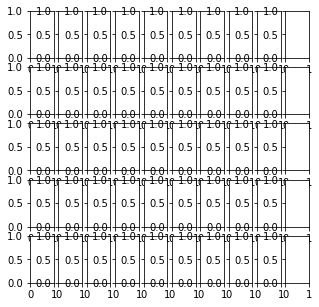

In [1]:
import matplotlib.pyplot as plt
W_grid = 10
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (5,5))
 
axes = axes.ravel() 
 
n_training = len(X_train) # get the length of the training dataset
 
# Select a random number from 0 to n_training
for i in np.arange(0, L_grid * W_grid): # create evenly spaces variables 
     # Select a random number
     index = np.random.randint(0, n_training)
     # read and display an image with the selected index    
     axes[i].imshow( X_train[index])
     axes[i].set_title(y_train[index], fontsize = 15)
     axes[i].axis('off')